In [ ]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

from qec_variables import *

Assumption for euler method solution for the stochastic master equation (SME)

\begin{equation}
t_{op}\Omega_{0} >> 1
\end{equation}


In [197]:
# Parameters
gamma_m = 1               # measurement strength
Omega_0 = 0.1 * gamma_m   # Hamiltonian strength
sigma = 50 / gamma_m      # pulse width
top = 500 / gamma_m       # t_op the time of evolution
gamma = 1.25e-3 * gamma_m # bit flip error rate
gamma = 0.5e-3 * gamma_m # bit flip error rate
eta = 1                   # quantum efficiency (1 for ideal detectors)
tau = 2.5 / gamma_m       # measurement time parameter
dt = 0.1 / gamma_m        # time step



# Thresholds
theta1 = -0.54
# theta1 = 0.25
theta2 = 0.8

In [198]:
tlist = np.arange(0, top, dt)

# Filtering constant
alpha = dt / tau

# Pauli matrices and identity
I, X, Z = qeye(2), sigmax(), sigmaz()

In [199]:
def op_on_qubit(op, i, N=3):
    return tensor([op if k == i else I for k in range(N)])

In [200]:
# Pauli operators on 3 qubits
X1, X2, X3 = [op_on_qubit(X, i) for i in range(3)]
Z1, Z2, Z3 = [op_on_qubit(Z, i) for i in range(3)]

# Stabilizers
S1 = Z1 * Z2
S2 = Z2 * Z3

# Collapse operators (bit-flip noise)
c_ops = [np.sqrt(gamma) * i for i in [X1, X2, X3]]

# Initial state: logical |0_L> = |000>
psi0 = tensor(basis(2,0), basis(2,0), basis(2,0))
rho = ket2dm(psi0)

# Target logical states for fidelity
zero = tensor(basis(2,0), basis(2,0), basis(2,0))
one  = tensor(basis(2,1), basis(2,1), basis(2,1))

state3 = tensor(basis(2,0), basis(2,0), basis(2,1))
state4 = tensor(basis(2,0), basis(2,1), basis(2,0))
state5 = tensor(basis(2,0), basis(2,1), basis(2,1))
state6 = tensor(basis(2,1), basis(2,0), basis(2,0))
state7 = tensor(basis(2,1), basis(2,0), basis(2,1))
state8 = tensor(basis(2,1), basis(2,1), basis(2,0))

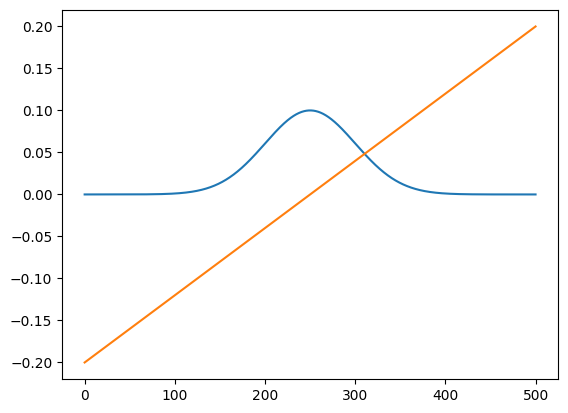

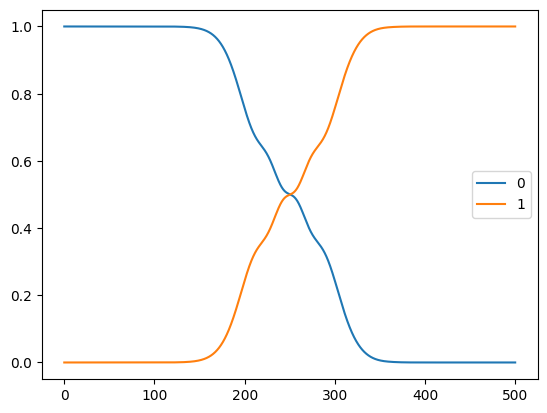

In [201]:
omega_t = lambda t: Omega_0 * np.exp(-0.5 * ((t - top / 2) / sigma) ** 2)
delta_t = lambda t: 2*Omega_0 * (t / (top / 2) - 1)


X_L = X1 * X2 * X3
# Z_L = (Z1 + Z2 + Z3) / 3
Z_L = tensor(Z, Z, Z)  # Using Z on all qubits for simplicity
I_L = tensor([I, I, I])

H = lambda t: X_L*omega_t(t) + Z_L*delta_t(t)

results = sesolve(H, psi0, tlist, e_ops=[zero*zero.dag(), one*one.dag()], )

plt.plot(tlist, omega_t(tlist))
plt.plot(tlist, delta_t(tlist))
plt.show()

plt.plot(tlist, results.expect[0], label='0')
plt.plot(tlist, results.expect[1], label='1')
plt.legend()
plt.show()

In [202]:
# # Chebyshev filtering parameters
# cheb_degree = 2
# cheb_a = 1e-3
# sigma = 50 / gamma_m  # Pulse width
#
# def rescale_H(H):
#     evals = H.eigenenergies()
#     E_min, E_max = np.min(evals), np.max(evals)
#     return (-2 * Omega_0 * H - (E_max + E_min) * I_L) / (E_max - E_min)
#
# def chebyshev_filter(rho, H_rescaled, degree=cheb_degree, a=cheb_a):
#     T0 = rho
#     T1 = H_rescaled * rho
#     filtered = T0 + 2 * np.exp(-a * 1) * T1
#
#     for n in range(2, degree):
#         Tn = 2 * H_rescaled * T1 - T0
#         coeff = 2 * np.exp(-a * n)
#         filtered += coeff * Tn
#         T0, T1 = T1, Tn
#
#     # Normalize trace to 1
#     return filtered.unit()

In [203]:
# Initialize filtered stabilizer signals
I1_bar, I2_bar = 0.0, 0.0

# Record fidelity
fidelities_0 = []
fidelities_1 = []
fidelities_3 = []
fidelities_4 = []
fidelities_5 = []
fidelities_6 = []
fidelities_7 = []
fidelities_8 = []

fidelities_0_L = []
fidelities_1_L = []
errors = []


I1s = []
I2s = []

# Time evolution loop
for t in tlist:
    # Hamiltonian
    
    # a = 1 - t/top
    # b = t/top
    # H = -Omega_0 * (a * X1 * X2 * X3 + b * (Z1 + Z2 + Z3)/3)
            
    H = (X1 * X2 * X3)*omega_t(t) + Z_L*delta_t(t)

    # Effective SME step
    dW1, dW2, dW_H = np.random.normal(scale=np.sqrt(dt), size=3)

    meas1 = np.sqrt(2 * gamma_m * eta) * (S1 * rho + rho * S1 - 2 * expect(S1, rho) * rho)
    meas2 = np.sqrt(2 * gamma_m * eta) * (S2 * rho + rho * S2 - 2 * expect(S2, rho) * rho)
    meas_H = np.sqrt(2 * gamma_m * eta) * (H * rho + rho * H - 2 * expect(H, rho) * rho)

    drho = -1j * (H * rho - rho * H)
    for c in c_ops:
        drho += c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c)
        
    drho += gamma_m * (S1 * rho * S1 - 0.5 * (S1**2 * rho + rho * S1**2))
    drho += gamma_m * (S2 * rho * S2 - 0.5 * (S2**2 * rho + rho * S2**2))
    
    # drho += meas1 * dW1 + meas2 * dW2 + meas_H * dW_H
    drho += meas1 * dW1 + meas2 * dW2

    rho = (rho + dt * drho).unit()

    # Measurement currents (with noise)
    I1 = expect(S1, rho) + dW1 / np.sqrt(dt)
    I2 = expect(S2, rho) + dW2 / np.sqrt(dt)
    

    # # Exponential filtering
    I1_bar = (1 - alpha) * I1_bar + alpha * I1
    I2_bar = (1 - alpha) * I2_bar + alpha * I2

    I1s.append(I1_bar)
    I2s.append(I2_bar)


    ###############
    # # Apply Chebyshev filtering every few steps
    # if t % 10 == 0:  # Apply filtering every 10 steps
    #
    #     H_rescaled = rescale_H(H)
    #     rho = chebyshev_filter(rho, H_rescaled)

    # I1s.append(I1)
    # I2s.append(I2)
    #################

    # Double threshold logic
    if I1_bar < theta1 and I2_bar > theta2:
        rho = X1 * rho * X1
        I1_bar, I2_bar = 1, 1
        errors.append(("X1", t))
    elif I1_bar < theta1 and I2_bar < theta1:
        rho = X2 * rho * X2
        I1_bar, I2_bar = 1, 1
        errors.append(("X2", t))
    elif I1_bar > theta2 and I2_bar < theta1:
        rho = X3 * rho * X3
        I1_bar, I2_bar = 1, 1
        errors.append(("X3", t))
    
    # fidelities.append((psi_target.dag() * rho * psi_target))
    fidelities_0.append(np.abs(zero.dag() * rho * zero))
    fidelities_1.append(np.abs(one.dag() * rho * one))
    fidelities_3.append(np.abs(state3.dag() * rho * state3))
    fidelities_4.append(np.abs(state4.dag() * rho * state4))
    fidelities_5.append(np.abs(state5.dag() * rho * state5))
    fidelities_6.append(np.abs(state6.dag() * rho * state6))
    fidelities_7.append(np.abs(state7.dag() * rho * state7))
    fidelities_8.append(np.abs(state8.dag() * rho * state8))

In [204]:
# Initial state: logical |0_L> = |000>
rho = ket2dm(psi0)

# Record fidelity
fidelities_0_no_meas = []
fidelities_1_no_meas = []

# Time evolution loop
for t in tlist:
    H = (X1 * X2 * X3)*omega_t(t) + ((Z1 + Z2 + Z3)/3)*delta_t(t)

    drho = -1j * (H * rho - rho * H)
    for c in c_ops:
        drho += c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c)
    
    rho = (rho + dt * drho).unit()

    fidelities_0_no_meas.append(np.abs(zero.dag() * rho * zero))
    fidelities_1_no_meas.append(np.abs(one.dag() * rho * one))

[('X3', np.float64(124.80000000000001)), ('X1', np.float64(449.5))]


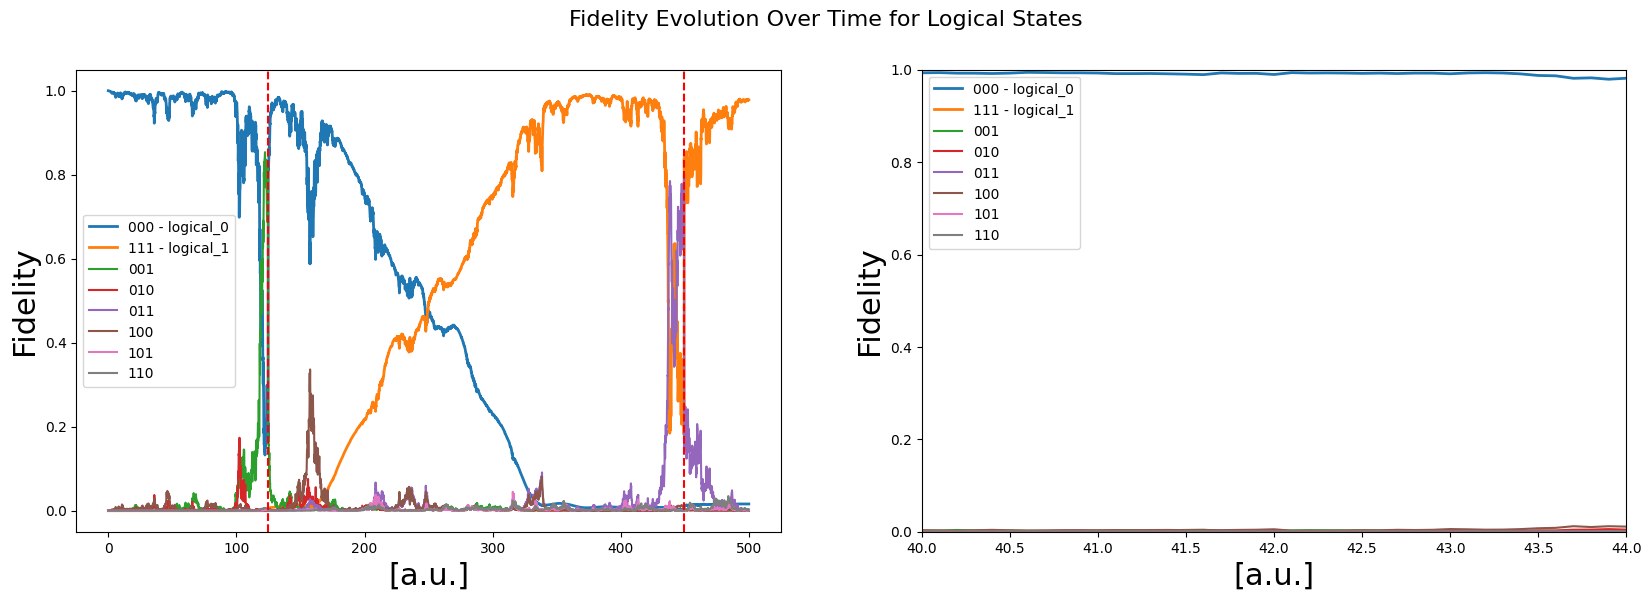

In [205]:
print(errors)

fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 2 rows, 1 column


axes[1].plot(tlist, fidelities_0, label='000 - logical_0', linewidth=2)
axes[1].plot(tlist, fidelities_1, label='111 - logical_1', linewidth=2)
axes[1].set_xlim([40, 44])
axes[1].set_ylim([0, 1])
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Fidelity")

axes[1].plot(tlist, fidelities_3, label='001')
axes[1].plot(tlist, fidelities_4, label='010')
axes[1].plot(tlist, fidelities_5, label='011')
axes[1].plot(tlist, fidelities_6, label='100')
axes[1].plot(tlist, fidelities_7, label='101')
axes[1].plot(tlist, fidelities_8, label='110')
axes[1].legend()

axes[0].plot(tlist, fidelities_0, label='000 - logical_0', linewidth=2)
axes[0].plot(tlist, fidelities_1, label='111 - logical_1', linewidth=2)
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Fidelity")
axes[0].plot(tlist, fidelities_3, label='001')
axes[0].plot(tlist, fidelities_4, label='010')
axes[0].plot(tlist, fidelities_5, label='011')
axes[0].plot(tlist, fidelities_6, label='100')
axes[0].plot(tlist, fidelities_7, label='101')
axes[0].plot(tlist, fidelities_8, label='110')
axes[0].legend()

# plt.xlim([350, 370])
# plt.ylim([0, 1])
for e in errors:
    axes[0].axvline(x=e[1], color='red', linestyle='--', label=e[0])  # Add this line
    axes[1].axvline(x=e[1], color='red', linestyle='--', label=e[0])  # Add this line


axes[0].set_xlabel("[a.u.]", size=22)
axes[1].set_xlabel("[a.u.]", size=22)
axes[0].set_ylabel("Fidelity", size=22)
axes[1].set_ylabel("Fidelity", size=22)
fig.suptitle("Fidelity Evolution Over Time for Logical States", fontsize=16)
plt.show()

# fig.savefig("3qubit_corr.svg", format="svg", dpi=300)
# fig.savefig("3qubit_corr.pdf", format="pdf", dpi=300)
# fig.savefig("3qubit_corr.pdf")
# fig.close()

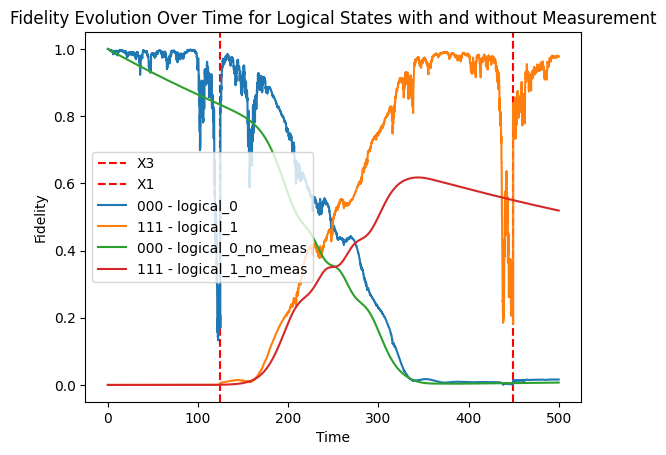

In [206]:
rho = ket2dm(psi0)

# Record fidelity
fidelities_0_no_meas = []
fidelities_1_no_meas = []

# Time evolution loop
for t in tlist:
    H = (X1 * X2 * X3)*omega_t(t) + ((Z1 + Z2 + Z3)/3)*delta_t(t)

    drho = -1j * (H * rho - rho * H)
    for c in c_ops:
        drho += c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c)
    
    rho = (rho + dt * drho).unit()

    fidelities_0_no_meas.append((zero.dag() * rho * zero))
    fidelities_1_no_meas.append((one.dag() * rho * one))


for e in errors:
    plt.axvline(x=e[1], color='red', linestyle='--', label=e[0])  # Add this line
    
    
plt.plot(tlist, fidelities_0, label='000 - logical_0')
plt.plot(tlist, fidelities_1, label='111 - logical_1')
plt.plot(tlist, fidelities_0_no_meas, label='000 - logical_0_no_meas')
plt.plot(tlist, fidelities_1_no_meas, label='111 - logical_1_no_meas')

plt.title("Fidelity Evolution Over Time for Logical States with and without Measurement")
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.legend()
plt.show()

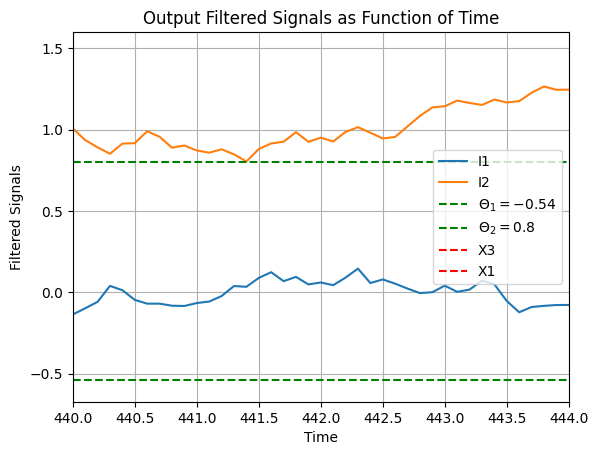

In [207]:
plt.plot(tlist, I1s, label='I1')
plt.plot(tlist, I2s, label='I2')
plt.axhline(theta1, color='green', linestyle='--', label=r'$\Theta_1 = -0.54$')
plt.axhline(theta2, color='green', linestyle='--', label=r'$\Theta_2 = 0.8$')
for e in errors:
    plt.axvline(x=e[1], color='red', linestyle='--', label=e[0])  # Add this line
    
    
plt.xlim([440, 444])# Initial state: logical |0_L> = |000>

plt.xlabel('Time')
plt.ylabel('Filtered Signals')
plt.title('Output Filtered Signals as Function of Time')
plt.grid(True)
plt.legend()
plt.show()